In [1]:
# utilities needed for our code
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [2]:
# reading the csv file given to us
df = pd.read_excel(r"C:\Users\vedik\OneDrive\Documents\csv_data\FlowerData.xlsx")
df.head()

,Petal.Length,Petal.Width,Species,InitialAssignment
0,1.4,0.2,setosa,1
1,1.4,0.2,setosa,1
2,1.3,0.2,setosa,2
3,1.5,0.2,setosa,3
4,1.4,0.2,setosa,2


In [3]:
def euclidean(centroid, data):
    '''
    takes in 2 p-dimensional series and returns the distance between the points represented by the series
    '''
    dist = (centroid-data).map(lambda x:x*x).sum()
    return np.sqrt(dist)

In [4]:
def KMeans(df):
    '''
    This function expects a dataframe with scaled data columns plus an additional column with an Initial Cluster guess
    
    1. Loop over all the centroids, grouped by InitialAssignment
    2. Calculate the Euclidean distance that the centroid is away from each datapoint in the cluster it belongs to
    3. Square and summation of the distance
    4. Repeat the above steps till the InitialAssignment and NewAssignment values are equal.
    '''
    
    columns = [x for x in df.columns if x!="InitialAssignment"]
    centroids = df.groupby("InitialAssignment")[columns].mean()
    df["NewAssignment"] = df.apply(lambda x:(centroids.apply(lambda y: euclidean(x,y),axis=1).idxmin()),axis=1)
    while not df["InitialAssignment"].equals(df["NewAssignment"]):
        df["InitialAssignment"] = df["NewAssignment"]
        centroids = df.groupby("InitialAssignment")[columns].mean()
        df["NewAssignment"] = df.apply(lambda x:(centroids.apply(lambda y: euclidean(x,y),axis=1).idxmin()),axis=1)
    return df

In [5]:
# calculate the Objective Value for Intra and Inter Cluster difference
def KMeans_objVal(df):
    '''
    This function expects a dataframe with only 3 columns, InitialAssignment, Petal.Length and Petal.Width
    
    '''
    
    columns = [x for x in df.columns if x!="InitialAssignment"]
    centroids = df.groupby("InitialAssignment")[columns].mean().reset_index()
    global_centroid = df[columns].mean()
    df_new = df.merge(centroids, on = "InitialAssignment", suffixes=["","_centroid"])
    df_new["Variance"] = df_new.apply(lambda x:(x["Petal.Length"]-x["Petal.Length_centroid"])**2+(x["Petal.Width"]-x["Petal.Width_centroid"])**2, 
                                      axis=1)
    
    return pd.Series({"Intra Cluster Variance":df_new["Variance"].sum(), 
                      "Inter Cluster Variance":centroids.apply(lambda x:euclidean(x, global_centroid)**2,axis=1).sum()})

In [6]:
# standardizing the units of measurement for each dimension  

scaledDF = StandardScaler().fit_transform(df[["Petal.Length", "Petal.Width"]])
scaledDF = pd.DataFrame(scaledDF,columns=["Petal.Length", "Petal.Width"])
scaledDF["InitialAssignment"] = df["InitialAssignment"]

# check the objective values before performing K-Means clustering
print("The objective values BEFORE performing K-Means clustering")
display(KMeans_objVal(scaledDF))

# perform K-Means on our scaled data
clusteredDF = KMeans(scaledDF)

# check the objective values after performing K-Means clustering
print("The objective values AFTER performing K-Means clustering")
display(KMeans_objVal(clusteredDF[["Petal.Length", "Petal.Width", "InitialAssignment"]]))

# comparing the previous guesses to our new predictions
clusteredDF["Initial_Guess"] = df["InitialAssignment"]

# putting back the species column because we did not use it to make predictions
clusteredDF["Species"] = df["Species"]

The objective values BEFORE performing K-Means clustering


Intra Cluster Variance    299.095632
Inter Cluster Variance      0.017975
dtype: float64

The objective values AFTER performing K-Means clustering


Intra Cluster Variance    18.026963
Inter Cluster Variance     5.727789
dtype: float64

In [7]:
# the dataframe with the predictions
clusteredDF

,Petal.Length,Petal.Width,InitialAssignment,NewAssignment,Initial_Guess,Species
0,-1.340227,-1.315444,1,1,1,setosa
1,-1.340227,-1.315444,1,1,1,setosa
2,-1.397064,-1.315444,1,1,2,setosa
3,-1.283389,-1.315444,1,1,3,setosa
4,-1.340227,-1.315444,1,1,2,setosa
...,...,...,...,...,...,...
145,0.819596,1.448832,3,3,1,virginica
146,0.705921,0.922303,3,3,3,virginica
147,0.819596,1.053935,3,3,1,virginica
148,0.933271,1.448832,3,3,2,virginica


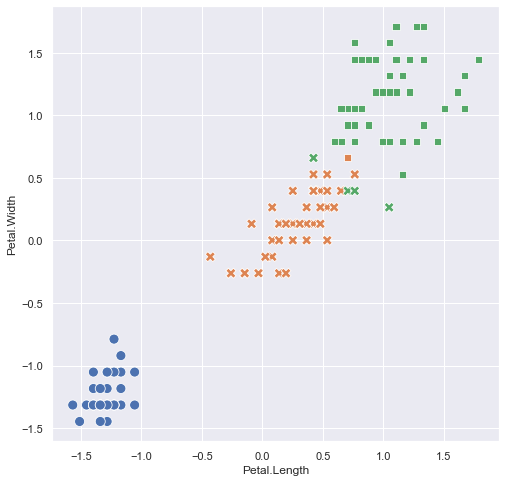

In [8]:
# plot the predictions we got
sns.set(rc={"figure.figsize":(8, 8)}) 
sns.scatterplot(x=clusteredDF["Petal.Length"],
                y=clusteredDF["Petal.Width"],
                hue=clusteredDF["Species"], # the actual data given to us
                style=clusteredDF["NewAssignment"], # my predictions
                palette="deep",
                legend=None, s=100)
plt.show()

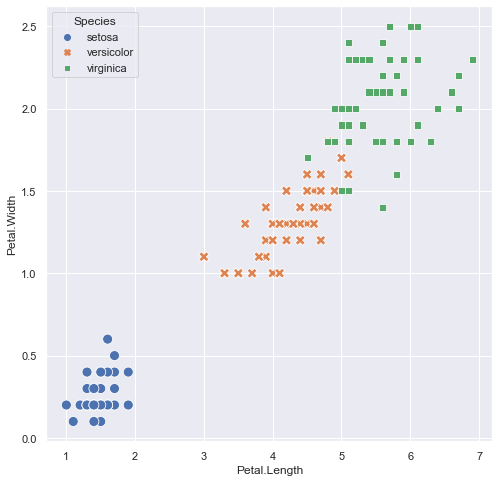

In [9]:
# plot the Original Dataset for comparison
sns.set(rc={"figure.figsize":(8, 8)}) 
sns.scatterplot(x=df["Petal.Length"],
                y=df["Petal.Width"],
                hue=df["Species"], # the actual data given to us
                style=df["Species"], # the first initialized vectors which was given
                palette="deep",
                s=100)
plt.show()